In [15]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
root_folder = "/docs/src/kt/data"
series_folder = "/docs/src/kt/data_by_series"
resized_series_folder = "/docs/src/kt/data_by_series_resized"
IMAGES_PATH = "/docs/src/kt/data_by_series_resized_images"
MIN_NUMBER_OF_PHOTO = 100
EMPTY_VALUE = 0

patients = os.listdir(series_folder)
patients.sort()

curr_patient = "Dimakova A.I. - Body 1.0"
curr_scan_set = "16"

In [7]:
def load_scan(path):
    slices = [pydicom.dcmread(path + "/" + _) for _ in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness  = slice_thickness

    return slices


In [8]:
def get_pixel_hu(slices):
    image = np.stack([_.pixel_array for _ in slices])
    image = image.astype(np.int16)

    image[image == -2000] = 0

    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].as_type(np.float64)
            image[slice_number] = image[slice_number].as_type(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)
    

In [16]:
print("curr patient/scan set:", curr_patient, "/", curr_scan_set)
slices = load_scan(series_folder + "/" + curr_patient + "/" + curr_scan_set)
image = get_pixel_hu(slices)

# plt.hist(image.flatten(), bins=100)

curr patient/scan set: Dimakova A.I. - Body 1.0 / 16


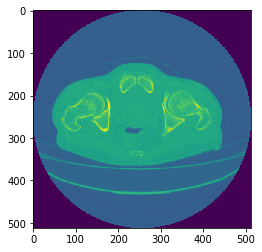

In [10]:
plt.imshow(image[100])

In [13]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    print("curr spacing:", spacing)

    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [18]:
resampled_image, new_spacing = resample(image, slices, [2,2,2])

print("new spacing", new_spacing)
print("original image shape", image.shape)
print("resampled image shape", resampled_image.shape)


curr spacing: [0.8   0.782 0.782]
new spacing [1.9981221  2.00192001 2.00192001]
original image shape (532, 512, 512)
resampled image shape (213, 200, 200)


(array([6.0000000e+00, 9.0000000e+00, 1.1000000e+01, 2.3000000e+02,
        8.0700000e+02, 3.3600000e+03, 6.3097000e+04, 1.4295900e+05,
        2.6783300e+05, 2.0848560e+07, 3.9211000e+04, 4.3969000e+04,
        3.0201000e+04, 3.5374000e+04, 2.8621000e+04, 4.2061000e+04,
        2.2817000e+04, 2.6210000e+04, 4.2426000e+04, 2.8842000e+04,
        2.3105000e+04, 3.2577000e+04, 4.8058000e+04, 1.7688300e+05,
        2.4673285e+07, 1.2462777e+07, 8.2436210e+06, 2.8236650e+06,
        9.8421300e+05, 5.6601100e+05, 4.2093200e+05, 3.5456700e+05,
        3.1818400e+05, 3.0463100e+05, 2.9075300e+05, 2.8434900e+05,
        2.9831800e+05, 3.8871800e+05, 2.5534330e+06, 4.5544930e+06,
        8.8671020e+06, 5.6042170e+06, 1.6598380e+06, 7.3117600e+05,
        4.9222700e+05, 3.2892200e+05, 2.3598200e+05, 1.7864700e+05,
        1.3257700e+05, 1.0232000e+05, 7.9244000e+04, 6.2625000e+04,
        4.9812000e+04, 3.8527000e+04, 3.0048000e+04, 2.3202000e+04,
        1.7830000e+04, 1.4311000e+04, 1.1161000e

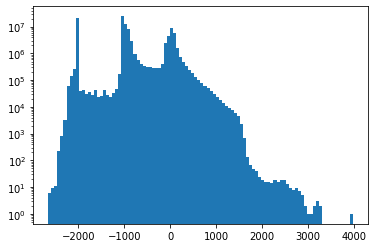

In [8]:
plt.hist(resampled_image.flatten(), bins=100, log=True)

(array([4.3989064e+07, 0.0000000e+00, 0.0000000e+00, 4.1000000e+01,
        2.3400000e+02, 7.4900000e+02, 1.8810000e+03, 7.1810000e+03,
        1.8315068e+07, 6.9923028e+07, 1.1924384e+07, 2.4927280e+06,
        1.4096310e+06, 1.1432420e+06, 1.0454620e+06, 1.0311590e+06,
        3.2126000e+06, 1.7606919e+07, 2.4884354e+07, 4.0661710e+06,
        1.6348980e+06, 8.6000800e+05, 5.1663000e+05, 3.2821400e+05,
        2.1533400e+05, 1.4198100e+05, 9.2523000e+04, 5.9308000e+04,
        4.0095000e+04, 2.7900000e+04, 1.8408000e+04, 6.1280000e+03,
        5.9600000e+02, 1.6300000e+02, 7.7000000e+01, 8.7000000e+01,
        8.0000000e+01, 4.1000000e+01, 5.6000000e+01, 6.2000000e+01,
        3.9000000e+01, 3.0000000e+01, 2.2000000e+01, 9.0000000e+00,
        1.0000000e+01, 6.0000000e+00, 3.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 3.0000000e+00]),
 array([-2048. , -1933.1, -1818.2, -1703.3, -1588.4, -1473.5, -1358.6,
        -1243.7, -1128.8, -1013.9,  -899. ,  -784.1,  -669.2,  -554.3,
  

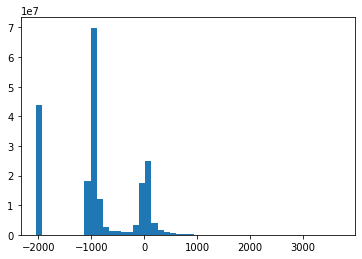

In [98]:
plt.hist(image.flatten(), bins=50)

In [103]:
image[image>2500]

array([2566, 2922, 2898, 2738, 2568, 2671, 2534, 2532, 2953, 3155, 3065,
       2910, 3132, 3098, 2594, 2567, 2541, 2501, 2505, 3065, 3183, 3094,
       2920, 2804, 3243, 3173, 2637, 2558, 2513, 2502, 3010, 3135, 3049,
       2832, 2702, 3079, 2988, 2525, 2544, 2546, 2587, 2593, 2551, 2765,
       3000, 2926, 2576, 2544, 2561, 2703, 2572, 2513, 2557, 2601, 2642,
       2685, 2643, 2566, 2559, 2588, 2624, 2699, 2663, 2645, 2644, 2514,
       2646, 2671, 2712, 2737, 2676, 2501, 2518, 2541, 2662, 2775, 2829,
       2818, 2615, 2614, 2715, 2595, 2782, 2867, 2879, 2751, 2610, 2821,
       2668, 2765, 2853, 2883, 2789, 2525, 2833, 2769, 2780, 2865, 2876,
       2808, 2551, 2757, 2777, 2715, 2858, 2849, 2794, 2602, 2554, 2658,
       2760, 2786, 2733, 2616, 2540, 2670, 2637, 2595, 2659, 2596, 2724,
       2920, 2745, 3100, 3247, 2529, 2863, 2695, 2811, 2590, 3587, 3661,
       2727, 3421, 3697, 3104, 3116, 3189, 3241, 2684, 2609, 2770],
      dtype=int16)

In [12]:
def plot_3d(image, threshold = -300):
    rotated_image = image.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(rotated_image, threshold, step_size=1, allow_degenerate=True)

    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111, projection = '3d')
    
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    mesh.set_facecolor([0.5, 0.5, 0.75])
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, rotated_image.shape[0])
    ax.set_ylim(0, rotated_image.shape[1])
    ax.set_zlim(0, rotated_image.shape[2])
    
    plt.show()
    

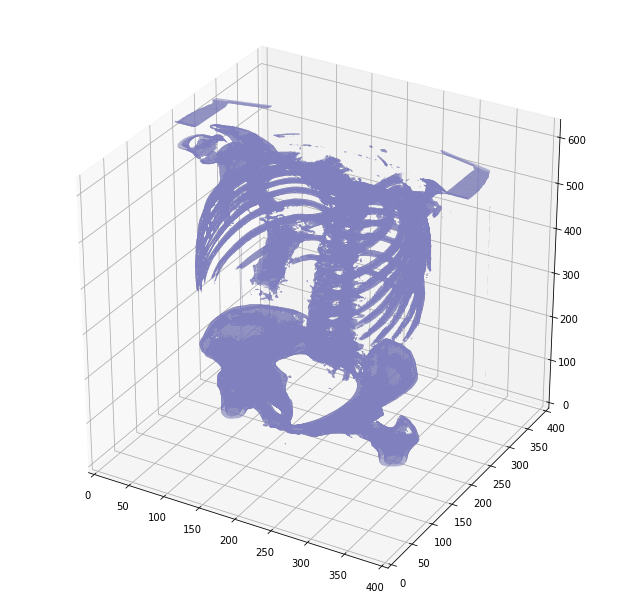

In [10]:
plot_3d(resampled_image, 400)

In [8]:
# from mayavi import mlab

# def plot_3d(image, threshold = -300):
#     rotated_image = image.transpose(2, 1, 0)
#     verts, faces, normals, values = measure.marching_cubes_lewiner(rotated_image, threshold, step_size=1, allow_degenerate=True)
    
#     mlab.triangular_mesh([vert[0] for vert in verts],
#                          [vert[1] for vert in verts],
#                          [vert[2] for vert in verts],
#                          faces) 

#     mlab.show() # --- this line stucks for some reasons


In [ ]:
plot_3d(resampled_image, 400)

----------
----------


In [13]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    binary_image = np.array(image > -320, dtype=np.int8) + 1
    print(np.unique(binary_image, return_counts=True))
    labels = measure.label(binary_image)
    background_labels = labels[0, 0, 0]
    
    binary_image[labels == background_labels] = 1
    print(np.unique(binary_image, return_counts=True))

    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    print(np.unique(binary_image, return_counts=True))

    binary_image[labels == background_labels] = 2
    print(np.unique(binary_image, return_counts=True))

    binary_image -= 1
    binary_image = 1 - binary_image
    print(np.unique(binary_image, return_counts=True))

    labels = measure.label(binary_image, background=0)
    largest_value = largest_label_volume(labels, bg=0)
    
    print("largest_volume_label:", largest_value)
    
    if largest_value is not None:
        binary_image[labels != largest_value] = 0

    print(np.unique(binary_image, return_counts=True))
    
    return binary_image

In [14]:
segmented_lungs = segment_lung_mask(resampled_image, False)
print()
segmented_lungs_fill = segment_lung_mask(resampled_image, True)

(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([ 5112288, 95047712], dtype=int64))
(array([0, 1], dtype=int8), array([95047712,  5112288], dtype=int64))
largest_volume_label: 782
(array([0, 1], dtype=int8), array([95255758,  4904242], dtype=int64))

(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([74729697, 25430303], dtype=int64))
(array([1, 2], dtype=int8), array([ 6379026, 93780974], dtype=int64))
(array([0, 1], dtype=int8), array([93780974,  6379026], dtype=int64))
largest_volume_label: 1161
(array([0, 1], dtype=int8), array([95143297,  5016703], dtype=int64))


In [44]:
segmented_lungs = segment_lung_mask(resampled_image, False)
print()
segmented_lungs_fill = segment_lung_mask(resampled_image, True)

(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([ 5112288, 95047712], dtype=int64))
(array([0, 1], dtype=int8), array([95047712,  5112288], dtype=int64))
largest_volume_label: 782
(array([0, 1], dtype=int8), array([95255758,  4904242], dtype=int64))

(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([73462959, 26697041], dtype=int64))
(array([1, 2], dtype=int8), array([74729697, 25430303], dtype=int64))
(array([1, 2], dtype=int8), array([ 6379026, 93780974], dtype=int64))
(array([0, 1], dtype=int8), array([93780974,  6379026], dtype=int64))
largest_volume_label: 1161
(array([0, 1], dtype=int8), array([95143297,  5016703], dtype=int64))


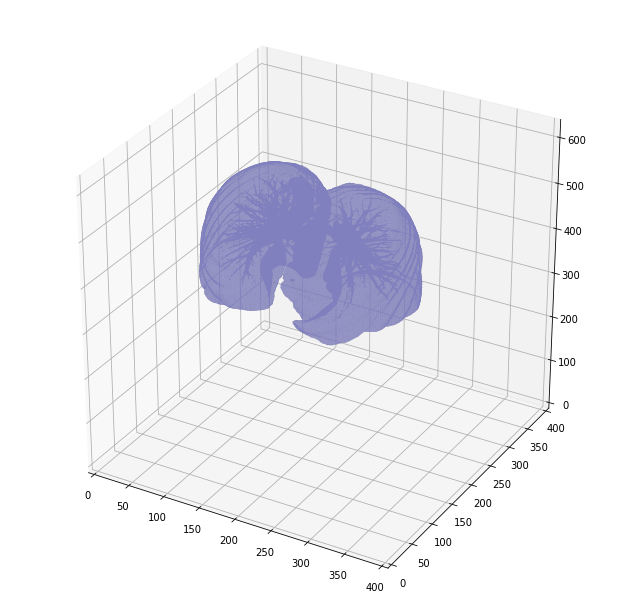

In [27]:
plot_3d(segmented_lungs, 0)

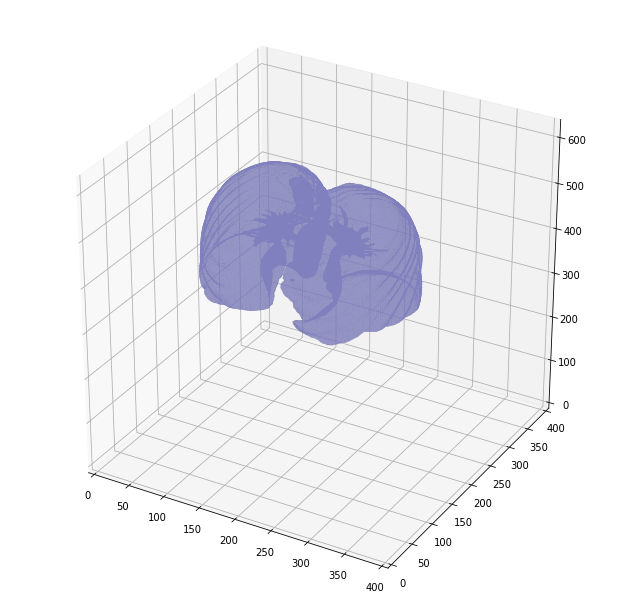

In [42]:
plot_3d(segmented_lungs_fill, 0)

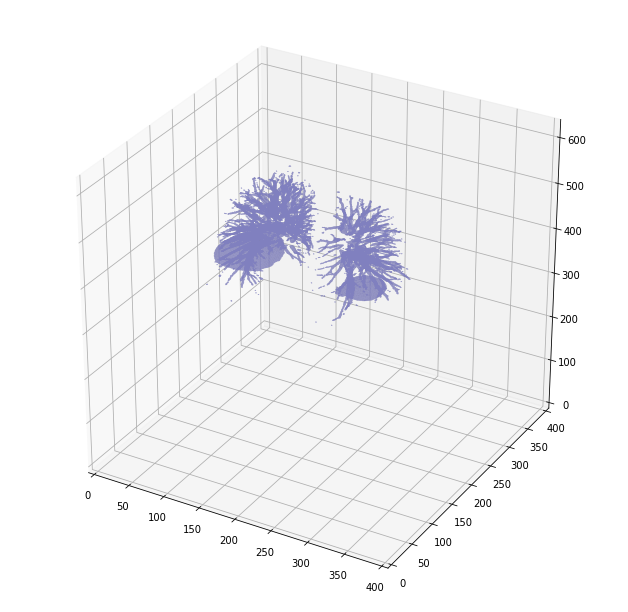

In [47]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

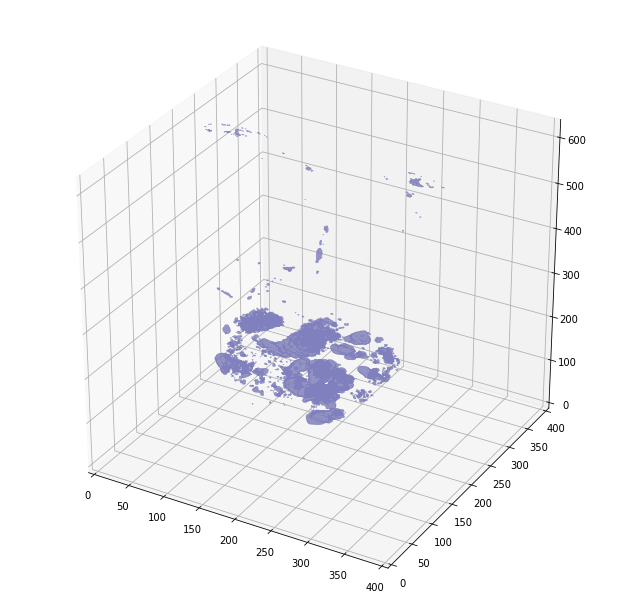

In [32]:
plot_3d(segmented_lungs, 0)

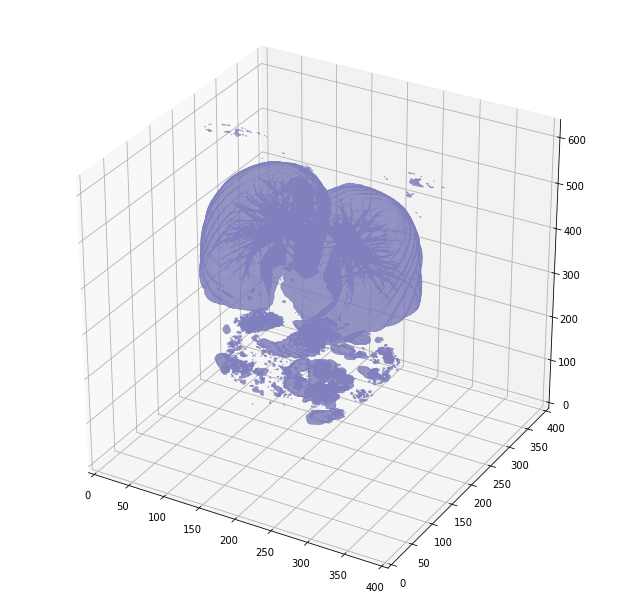

In [37]:
plot_3d(segmented_lungs, 0)

In [61]:
def segment_stomach_mask(image, fill_internal_structures=False):
    binary_image = np.array((image > 50) & (image < 51), dtype=np.int8) + 1
    print(np.unique(binary_image, return_counts=True))
#     labels = measure.label(binary_image)
#     background_labels = labels[0, 0, 0]
    
#     binary_image[labels == background_labels] = 2
#     print(np.unique(binary_image, return_counts=True))

#     # Method of filling the lung structures (that is superior to something like 
#     # morphological closing)
#     if fill_internal_structures:
#         # For every slice we determine the largest solid structure
#         for i, axial_slice in enumerate(binary_image):
#             axial_slice = axial_slice - 1
#             labeling = measure.label(axial_slice)
#             l_max = largest_label_volume(labeling, bg=0)
            
#             if l_max is not None: #This slice contains some lung
#                 binary_image[i][labeling != l_max] = 1

#     print(np.unique(binary_image, return_counts=True))

# #     binary_image[labels == background_labels] = 2
# #     print("-", np.unique(binary_image, return_counts=True))

#     binary_image -= 1
#     binary_image = 1 - binary_image
#     print(np.unique(binary_image, return_counts=True))

#     labels = measure.label(binary_image, background=0)
#     largest_value = largest_label_volume(labels, bg=0)
    
#     print("largest_volume_label:", largest_value)
    
#     if largest_value is not None:
#         binary_image[labels != largest_value] = 0

#     print(np.unique(binary_image, return_counts=True))
    
    return binary_image

In [62]:
segmented_50_70 = segment_stomach_mask(resampled_image)

(array([1, 2], dtype=int8), array([97698667,  2461333], dtype=int64))


In [ ]:
plot_3d(segmented_50_70, 1)

------- Animated gif

In [8]:
import matplotlib.animation as animation

def safe_gif(image, f_name):
    fig = plt.figure() # make figure

    im = plt.imshow(image[0], cmap=plt.cm.bone)

    # function to update figure
    def updatefig(j):
        # set the data in the axesimage object
        im.set_array(image[j])
        # return the artists set
        return im,
    # kick off the animation
    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(image)), 
                                  interval=50, blit=True)
    ani.save(f_name, writer='imagemagick')
#     plt.show()

In [29]:
# --- numpy save/load functionality
arr1 = np.arange(10, 100, 2)
np.save("arr1.npz", arr1)
arr2 = np.load("arr1.npz.npy")
arr2

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76,
       78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98])

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


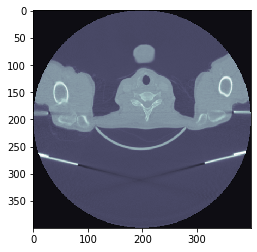

In [35]:
safe_gif(resampled_image, curr_patient + ".gif")

In [60]:
def remove_low_hu(image):
    image = np.copy(image)
    image[image < 0] = EMPTY_VALUE
    return image
def remove_high_hu(image):
    image = np.copy(image)
    binary_image = np.array(400 < image)
    image[binary_image] = EMPTY_VALUE
    return image
def remove_bones(image):
    image = np.copy(image)
    binary_image = np.array((380 < image) & (image < 420), dtype=np.int8)
    image[binary_image == 1] = EMPTY_VALUE
    return image
def leave_bones_only(image):
    image = np.copy(image)
    binary_image = np.array(300 < image, dtype=np.int8)
    image[binary_image == 0] = EMPTY_VALUE
    image[binary_image != 1] = 1
    return image

def remove_bg(image):
    image = np.copy(image)
    labels=measure.label(image)
    bg_pixel = labels[0,0,0]
    image[labels == bg_pixel] = EMPTY_VALUE
    return image

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


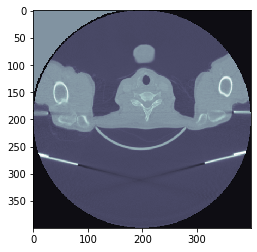

In [41]:
image_reduced_1 = remove_bg(resampled_image)
safe_gif(image_reduced_1, curr_patient + "_nobg.gif")

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


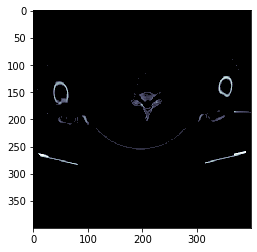

In [61]:
image_reduced_2 = leave_bones_only(image_reduced_1)
safe_gif(image_reduced_2, curr_patient + "_nobg_nobones.gif")

In [47]:
print(resampled_image.min(), "/", resampled_image.max())
print(image_reduced_1.min(), "/", image_reduced_1.max())
print(image_reduced_2.min(), "/", image_reduced_2.max())
print(np.unique(image_reduced_2))


-2654 / 3967
-2654 / 3967
0 / 419
[  0 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419]
